# Basic content filters

This first notebook demonstrates the use of basic input and output content filters. We will use Amazon Bedrock Guardrails as the tool, and use both basic trust and safety guardrails as well as topic filtering.

We will use the Guardrails API directly so we can obtain usage data for cost tracking. Once you are comfortable with the cost aspect of using guardrails, you can invoke the Guardrail as part of a higher-level SDK like the Strands Agent SDK for convenience.

## Scenario

We are building a chatbot for a city government. This chatbot will answer questions about the community.

We do not want the chatbot to answer specific real estate questions about property values or whether a particular property should be bought or sold.

## Prerequisites

Set up a Python environment and install the requirements in `requirements.txt`. For example, if you are using `uv`, run:

```
uv venv .venv
source .venv/bin/activate
uv pip install -r requirements.txt
```

You need AWS credentials set up in your workspace as well.

## Creating the Bedrock Guardrail

We will create a guardrail that defines prohibited topics and words to avoid, as well as standard trust and safety rules.

In [1]:
import boto3

client = boto3.client('bedrock')

In [4]:
import time
unique_id = str(round(time.time()))
create_response = client.create_guardrail(
    name=f"real-estate-advice-{unique_id}",
    description='Prevents the our model from providing real estate advice.',
    topicPolicyConfig={
        'topicsConfig': [
            {
                'name': 'Real Estate Advice',
                'definition': 'Providing advice or recommendations about real estate values or whether a specific property should be bought or sold.',
                'examples': [
                    'Is the real estate market in this neighborhood hot right now?',
                    'Is this house worth that much?',
                    'Should I sell now or wait until interest rates go down?',
                ],
                'type': 'DENY'
            }
        ]
    },
    contentPolicyConfig={
        'filtersConfig': [
            {
                'type': 'SEXUAL',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'VIOLENCE',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'HATE',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'INSULTS',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'MISCONDUCT',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'PROMPT_ATTACK',
                'inputStrength': 'HIGH',
                'outputStrength': 'NONE'
            }
        ]
    },
    wordPolicyConfig={
        'wordsConfig': [
            {'text': 'real estate advice'},
            {'text': 'good time to sell'},
            {'text': 'good time to buy'},
            {'text': 'real estate agent recommendations'}
        ],
        'managedWordListsConfig': [
            {'type': 'PROFANITY'}
        ]
    },
    sensitiveInformationPolicyConfig={
        'piiEntitiesConfig': [
            {'type': 'EMAIL', 'action': 'ANONYMIZE'},
            {'type': 'PHONE', 'action': 'ANONYMIZE'},
            {'type': 'NAME', 'action': 'ANONYMIZE'},
            {'type': 'US_SOCIAL_SECURITY_NUMBER', 'action': 'BLOCK'},
            {'type': 'US_BANK_ACCOUNT_NUMBER', 'action': 'BLOCK'},
            {'type': 'CREDIT_DEBIT_CARD_NUMBER', 'action': 'BLOCK'}
        ],
        'regexesConfig': [
            {
                'name': 'Account Number',
                'description': 'Matches account numbers in the format XXXXXX1234',
                'pattern': r'\b\d{6}\d{4}\b',
                'action': 'ANONYMIZE'
            }
        ]
    },
    blockedInputMessaging="""I can provide general info about the community, but can't fully address your request here. For personalized help or detailed questions, please contact our customer service team directly. For security reasons, avoid sharing sensitive information through this channel. If you have a general HOA question, feel free to ask without including personal details. """,
    blockedOutputsMessaging="""I can provide general info about the community, but can't fully address your request here. For personalized help or detailed questions, please contact our customer service team directly. For security reasons, avoid sharing sensitive information through this channel. If you have a general HOA question, feel free to ask without including personal details. """,
    tags=[
        {'key': 'purpose', 'value': 'real-estate-advice-prevention'},
        {'key': 'environment', 'value': 'production'}
    ]
)

print(create_response)

{'ResponseMetadata': {'RequestId': '093d6493-1082-4ea4-a1fe-c308cf918485', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Sat, 23 Aug 2025 15:39:43 GMT', 'content-type': 'application/json', 'content-length': '172', 'connection': 'keep-alive', 'x-amzn-requestid': '093d6493-1082-4ea4-a1fe-c308cf918485'}, 'RetryAttempts': 0}, 'guardrailId': 'rylps0tc67le', 'guardrailArn': 'arn:aws:bedrock:us-west-2:XXXXXXXXXXXX:guardrail/rylps0tc67le', 'version': 'DRAFT', 'createdAt': datetime.datetime(2025, 8, 23, 15, 39, 43, 567414, tzinfo=tzutc())}


In [5]:
version_response = client.create_guardrail_version(
    guardrailIdentifier=create_response['guardrailId'],
    description='First version of guardrail'
)

In [6]:
guardrail_id = create_response['guardrailId']
guardrail_id

'rylps0tc67le'

In [7]:
guardrail_version = version_response['version']
guardrail_version

'1'

## Using the guardrail

We will use the guardrail to inspect the user's prompt and the model's output.

### Setup

In [8]:
bedrock_runtime = boto3.client('bedrock-runtime')

In [9]:
model_id = 'us.amazon.nova-pro-v1:0'

In [10]:
# Convenience method that invokes the model using the Converse API.
# It returns a tuple of the output text and input and output token usage.
def chat(messages, system_prompts, model_id = model_id):

    # Send the message.
    response = bedrock_runtime.converse(
        modelId=model_id,
        messages=messages,
        system=system_prompts,
    )

    # Log token usage.
    token_usage = response['usage']
    output_message = response['output']['message']

    return output_message['content'][0]['text'], token_usage['inputTokens'], token_usage['outputTokens']


In [12]:
# Convenience method to call the Guardrail. 
def analyze_text(query, source, guard_content, guardrail_id, guardrail_version, grounding_source = None):
    try:
        content = [
            {
                "text": {
                    "text": query,
                    "qualifiers": ["query"]
                }
            },
            {
                "text": {
                    "text": guard_content,
                    "qualifiers": ["guard_content"]
                }
            }
        ]

        if grounding_source is not None:
            content.append(
                {
                    "text": {
                        "text": grounding_source,
                        "qualifiers": ["grounding_source"]
                    }
                }
            )

        response = bedrock_runtime.apply_guardrail(
            guardrailIdentifier=guardrail_id,
            guardrailVersion=guardrail_version,
            source=source,
            content=content
        )
        
        action = response.get("action", "")
        if action == "NONE":
            return True, "", response
        elif action == "GUARDRAIL_INTERVENED":
            message = response.get("outputs", [{}])[0].get("text", "Guardrail intervened")
            return False, message, response
        else:
            return False, f"Unknown action: {action}", response
    except Exception as e:
        return False, f"Error applying guardrail: {e}", None

In [16]:
# convenience method to calculate Guardrail cost
def calculate_guardrail_cost(guardrail_response):
    usage = guardrail_response['usage']

    content_filter_cost = 0.15 # per 1000 units
    content_filter_image_cost = 0.00075 # per image
    denied_topic_cost = 0.15 # per 1000 units
    sensitive_filter_cost = 0.1 # per 1000 units
    grounding_cost = 0.1 # per 1000 units
    ar_cost = 0.17 # per 1000 units per policy
    word_cost = 0 

    cost = usage['topicPolicyUnits'] * denied_topic_cost / 1000.0 + \
        usage['contentPolicyUnits'] * content_filter_cost / 1000.0 + \
        usage['wordPolicyUnits'] * word_cost + \
        usage['sensitiveInformationPolicyUnits'] * sensitive_filter_cost / 1000.0 + \
        usage['contextualGroundingPolicyUnits'] * grounding_cost / 1000.0 + \
        usage['contentPolicyImageUnits'] * content_filter_image_cost + \
        usage['automatedReasoningPolicyUnits'] * ar_cost  / 1000.0 * usage['automatedReasoningPolicies']

    return cost

In [20]:
# convenience method to calculate Nova Pro cost, not considering prompt caching
def calculate_llm_cost(tokens_in, tokens_out):
    nova_in_cost = 0.0008 # per thousand tokens
    nova_out_cost = 0.0032 # per thousand tokens

    cost = nova_in_cost * tokens_in / 1000.0 + \
        nova_out_cost * tokens_out / 1000.0
    
    return cost

### Inspect the input

In [11]:
system_prompts = [{"text": "You are a helpful assistant for our city. Your job is to inform and assist residents. You cannot provide any real estate advice."}]
message_1 = {
    "role": "user",
    "content": [{"text": "Tell me about San Francisco."}]
}

In [13]:
query = message_1['content'][0]['text'] 
prompt_passed, prompt_message, gr_response = analyze_text(
     query,
     "INPUT", 
     query, 
     guardrail_id,
     guardrail_version)

In [14]:
print(f"Prompt passed: {prompt_passed}")

Prompt passed: True


In [15]:
print(f"Guardrail message: {prompt_message}")

Guardrail message: 


In [17]:
calculate_guardrail_cost(gr_response)

0.00039999999999999996

### Invoke the LLM

In [18]:
r, t_in, t_out = chat([message_1], system_prompts)

In [19]:
print(f"Response: {r}")
print(f"Tokens: {t_in}, {t_out}")

Response: Certainly! San Francisco is a vibrant and culturally rich city located in Northern California. Here are some key points about San Francisco:

### Geography
- **Location:** Situated on a peninsula between the Pacific Ocean and San Francisco Bay.
- **Landmarks:** Famous for its steep hills, dense fog, and iconic landmarks like the Golden Gate Bridge and Alcatraz Island.

### History
- **Founding:** Established in 1776 by Spanish colonists.
- **Gold Rush:** Experienced rapid growth during the California Gold Rush in the mid-19th century.
- **Earthquake and Fire:** Rebuilt after the 1906 earthquake and subsequent fires.

### Culture
- **Diversity:** Home to a diverse population with significant communities of Asian, Latino, and European descent.
- **Arts:** Rich in museums, theaters, and music venues. Notable institutions include the San Francisco Museum of Modern Art and the San Francisco Symphony.

### Economy
- **Tech Hub:** Part of the Silicon Valley ecosystem, hosting numero

In [21]:
calculate_llm_cost(t_in, t_out)

0.0014656

### Inspect the output

In [22]:
prompt_passed, prompt_message, gr_response = analyze_text(
     query,
     "OUTPUT", 
     r, 
     guardrail_id,
     guardrail_version)

In [24]:
print(f"Prompt passed: {prompt_passed}")
print(f"Guardrail message: {prompt_message}")

Prompt passed: True
Guardrail message: 


In [25]:
calculate_guardrail_cost(gr_response)

0.0012

## Conclusion

This notebook showed the simple application of basic trust and safety guardrails, included prohibited topics.

As written, the costs incurred are:

* LLM call: $0.0014656
* Input guardrail: $0.00039999999999999996
* Output guardrail: $0.0012

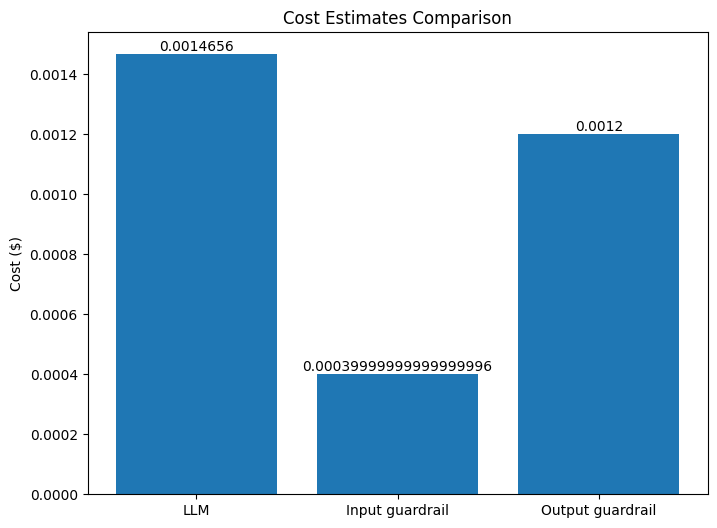

In [27]:
import matplotlib.pyplot as plt

estimates = [0.0014656, 0.00039999999999999996, 0.0012]  
labels = ["LLM", "Input guardrail", "Output guardrail"]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, estimates)

# Customize the chart
plt.title('Cost Estimates Comparison')
plt.ylabel('Cost ($)')

# Add value labels on top of each bar
for i, v in enumerate(estimates):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Display the chart
plt.show()